In [ ]:
!pip install keras_nlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 691.2/691.2 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 97.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 55.9 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import keras_nlp
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize

In [ ]:
nltk.download('punkt_tab')
stopwords = ['saya','rasa','dan','yang']
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stopwords]
    return ' '.join(filtered_tokens)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
file_path = "drive/Shareddrives/ML/Dataset/Balance/oversampled_train.csv"
stemmed_train_df = pd.read_csv(file_path)

texts = stemmed_train_df["text"].apply(preprocess_text).values
labels = stemmed_train_df["label"].values

dataset = tf.data.Dataset.from_tensor_slices((texts, labels))

In [ ]:
train_size = int(0.8 * len(texts))
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

In [ ]:
train_text = train_dataset.map(lambda text, label: text)
train_labels = train_dataset.map(lambda text, label: label)

test_text = test_dataset.map(lambda text, label: text)
test_labels = test_dataset.map(lambda text, label: label)

In [ ]:
VOCAB_PATH = "drive/Shareddrives/ML/Vocab/indonesian_vocab.txt"
subword_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=VOCAB_PATH
)

In [ ]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 128
PADDING_TYPE = 'pre'
TRUNC_TYPE = 'post'

In [ ]:
def padding_func(sequences):
  sequences = sequences.ragged_batch(batch_size=sequences.cardinality())

  sequences = sequences.get_single_element()

  padded_sequences = tf.keras.utils.pad_sequences(sequences.numpy(),
                                                  truncating=TRUNC_TYPE,
                                                  padding=PADDING_TYPE
                                                 )

  padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)

  return padded_sequences

In [ ]:
train_tokens = train_text.map(lambda x: subword_tokenizer.tokenize(x))
train_tokens = padding_func(train_tokens)

test_tokens = test_text.map(lambda x: subword_tokenizer.tokenize(x))
test_tokens = padding_func(test_tokens)

train_dataset = tf.data.Dataset.zip((train_tokens, train_labels))
test_dataset = tf.data.Dataset.zip((test_tokens, test_labels))

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(PREFETCH_BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(PREFETCH_BUFFER_SIZE)

In [ ]:
# Model parameters
EMBEDDING_DIM = 256
LSTM1_DIM = 128
LSTM2_DIM = 32
DENSE_DIM = 256
DROPOUT_RATE = 0.5

# EMBEDDING_DIM = 128
# LSTM1_DIM = 64
# LSTM2_DIM = 32
# DENSE_DIM = 128
# DROPOUT_RATE = 0.5

model = tf.keras.Sequential([
    tf.keras.Input(shape=(None,)),
    tf.keras.layers.Embedding(subword_tokenizer.vocabulary_size(), EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM1_DIM)),
    tf.keras.layers.Dropout(DROPOUT_RATE),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM1_DIM, return_sequences=True)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM2_DIM)),
    # tf.keras.layers.Dropout(DROPOUT_RATE),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    min_delta = 0.0001
)

# Buat adjust learning rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

NUM_EPOCHS = 100

history = model.fit(
    train_dataset,
    epochs=NUM_EPOCHS,
    validation_data=test_dataset,
    callbacks=[early_stopping, reduce_lr]
)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, None, 256)           │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,021,574 (11.53 MB)

 Trainable params: 3,021,574 (11.53 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.3861 - loss: 1.5398 - val_accuracy: 0.2556 - val_loss: 4.5893 - learning_rate: 5.0000e-04
Epoch 2/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.4915 - loss: 1.5275 - val_accuracy: 0.2556 - val_loss: 4.8006 - learning_rate: 5.0000e-04
Epoch 3/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.6186 - loss: 1.1053 - val_accuracy: 0.2536 - val_loss: 4.3072 - learning_rate: 5.0000e-04
Epoch 4/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.7355 - loss: 0.7836 - val_accuracy: 0.2541 - val_loss: 3.5395 - learning_rate: 5.0000e-04
Epoch 5/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.7870 - loss: 0.6311 - val_accuracy: 0.2539 - val_loss: 3.2112 - learning_rate: 5.0000e-04
Epoch 6/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.8049 - loss: 0.5867 - val_accuracy: 0.2542 - val_loss: 2.9469 - learning_rate: 5.0000e-04
Epoch 7/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 10s 5

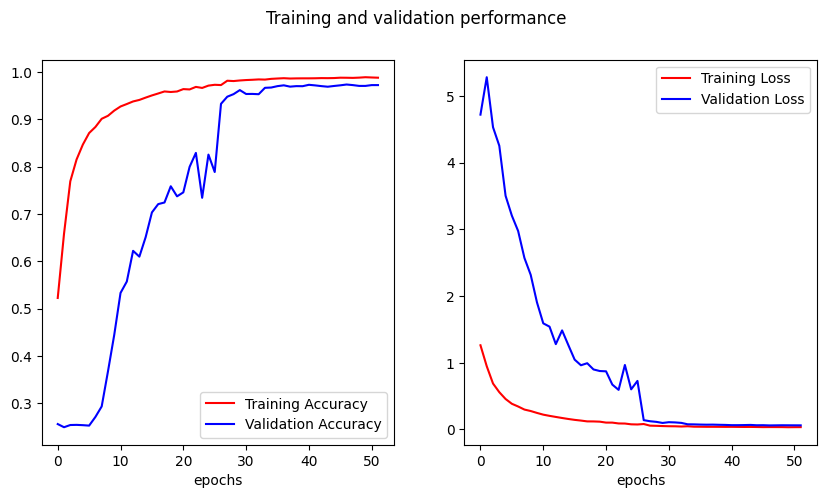

In [ ]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation performance')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

In [ ]:
model.save('drive/Shareddrives/ML/Models/model_lstm_new_3.h5')

# Predict

In [ ]:
import importlib.util

def check_and_install(library_name):
  spec = importlib.util.find_spec(library_name)
  if spec is None:
    print(f"{library_name} is not installed. Installing...")
    !pip install {library_name}
    print(f"{library_name} installed successfully.")
  else:
    print(f"{library_name} is already installed.")

check_and_install("keras_nlp")

keras_nlp is already installed.


In [ ]:
import tensorflow as tf
import numpy as np
import keras_nlp

In [ ]:
VOCAB_PATH = "drive/Shareddrives/ML/Vocab/indonesian_vocab.txt"
subword_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=VOCAB_PATH
)

In [ ]:
def predict_word(model, text, tokenizer):
  """Predicts the emotion label for a given text.

  Args:
    model: The trained TensorFlow model.
    text: The input text string.
    tokenizer: The tokenizer used for preprocessing the text.

  Returns:
    The predicted emotion label (0-5) and the corresponding emotion.
  """
  text = preprocess_text(text)
  tokens = tokenizer.tokenize(text)
  padded_tokens = tf.keras.utils.pad_sequences([tokens], maxlen=20, padding='pre', truncating='post')  # Assuming maxlen = 20

  prediction = model.predict(padded_tokens)

  predicted_label = np.argmax(prediction)

  emotion_mapping = {
      0: 'sedih',
      1: 'senang',
      2: 'love',
      3: 'marah',
      4: 'takut',
      5: 'terkejut'
  }

  predicted_emotion = emotion_mapping.get(predicted_label, "Unknown")

  return predicted_label, predicted_emotion

model = tf.keras.models.load_model('drive/Shareddrives/ML/Models/model_lstm_new_2.h5')
new_text = "Saya bangun kemarin Senin pagi dengan perasaan sedikit tertekan"
predicted_label, predicted_emotion = predict_word(model, new_text, subword_tokenizer)

print(f"Predicted label: {predicted_label}")
print(f"Predicted emotion: {predicted_emotion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
Predicted label: 4
Predicted emotion: takut


# Save To TFJS

In [ ]:
!pip install tensorflowjs

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 85.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tf-keras
    Found existing installation: tf_keras 2.17.0
    Uninstalling tf_keras-2.17.0:
      Successfully uninstalled tf_keras-2.17.0


In [ ]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, 'tfjs_model')

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 103.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tf-keras
    Found existing installation: tf_keras 2.17.0
    Uninstalling tf_keras-2.17.0:
      Successfully uninstalled tf_keras-2.17.0


failed to lookup keras version from the file,
    this is likely a weight only file


In [ ]:
!tensorflowjs_converter \
    --input_format=keras \
    --output_format=tfjs_layers_model \
    drive/Shareddrives/ML/Models/model_lstm_new_3.h5 \
    drive/Shareddrives/ML/Models/tfjs_model_new_3/

2024-12-09 16:19:51.344817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733761191.367995   52880 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733761191.374990   52880 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file
